こちらをもとに学習<br>
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

#　ライブラリのインポート

In [1]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

2022-12-04 13:52:27.329001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')

print('Training Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [3]:
print('訓練データ')
train_df.head()

訓練データ


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('テストデータ')
test_df.head()

テストデータ


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### データセットのカラムについて
・id・・・ツイートの一意なキー<br>・text・・・ツイートの文<br>・location・・・ツイートがどこから送られたか<br>
・keyword・・・ツイートのキーワード<br>・target・・・災害についてのツイートだったら「1」、そうでなければ「0」

# 【keywordとlocationについて】

## 欠損値について

keywordとlocationカラムでは、訓練データセットとテストデータセットは同じ割合の欠損値を所持している。<br>
* keywordカラムの全体の0.8%が欠損値となっている。
* locationカラムの全体の33%が欠損値となっている。

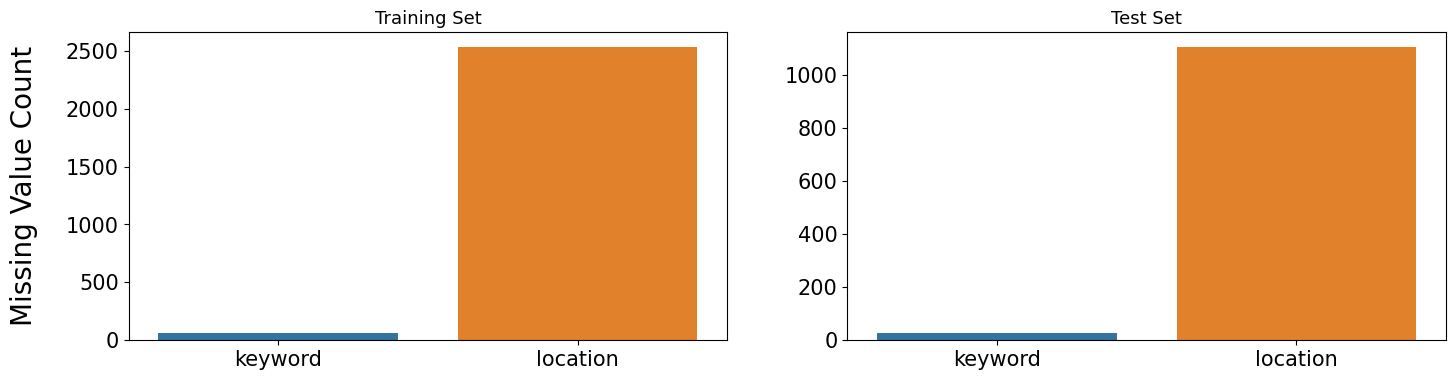

In [25]:
# 欠損値を数えるカラムをmissing_cols変数に入れる。
missing_cols = ['keyword', 'location']

fig, ax = plt.subplots(1, 2, figsize=(17, 4), dpi=100)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

background_color = '#f6f5f5'

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values, ax=ax[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values, ax=ax[1])

ax[0].set_ylabel('Missing Value Count', size=20, labelpad=20)

# tick_paramsで目盛りの細かい調整。
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Training Set', fontsize=13)
ax[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

## カーディナリティと目的変数の分布

Locationはユーザーのインプットで自動的に生成された。<br>
Locationカラムは表記の揺れなどで、ユニークな値が多く、特徴量に使われるべきではない。<br>

### カーディナリティについて

In [26]:
print(f'keywordカラムのユニークな値 = {train_df["keyword"].nunique()} (Training) - {test_df["keyword"].nunique()} (Test)')
print(f'locationカラムのユニークな値 = {train_df["location"].nunique()} (Training) - {test_df["location"].nunique()} (Test)')

keywordカラムのユニークな値 = 222 (Training) - 222 (Test)
locationカラムのユニークな値 = 3342 (Training) - 1603 (Test)


### 目的変数の分布について

下記のヒストグラムで、tweetにどのkeywordが使われていると、targetが1(災害に関すること）に分類されているか<br>
targetが0(災害に関係ないこと）に分類されているか読み取れる。

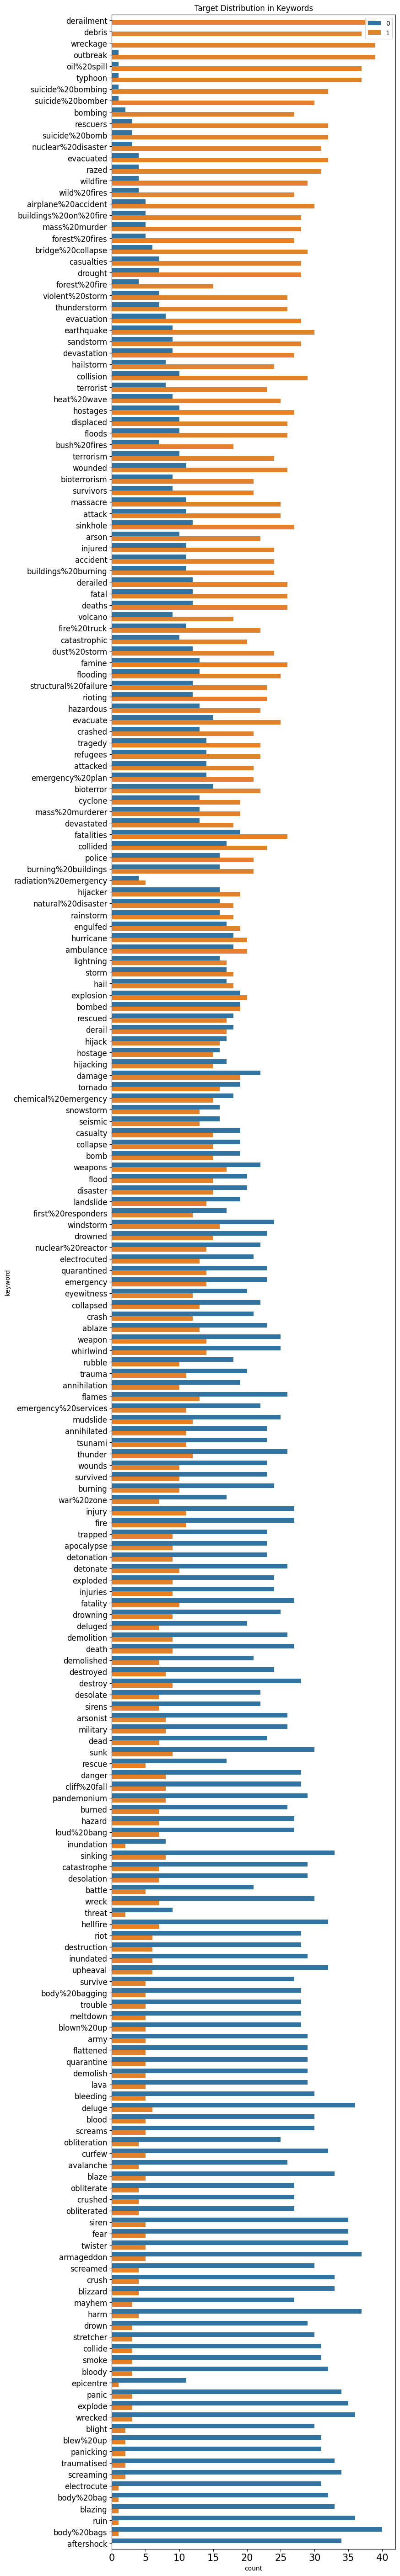

In [20]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

# countplotメソッドは、データの件数を集計し、ヒストグラムとして出力する。
# └hue・・・各軸をさらに分割して、集計する場合に利用する列名を指定。
# yにデータフレームを入れると横方向に、xに入れると縦方向になる。
sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword']
              , hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

# 作成したtarget_meanはtrain_dfデータフレームから除去しておく。
# train_df.drop(columns=['target_mean'], inplace=True)

(感じたこと)<br>
カラム内の値毎に,同じ表の中にヒストグラムを可視化するなら、seabornのcountplotを使った方が良い気がする。<br>
同じfig内で、異なるaxesにヒストグラムを可視化するなら、matplotlib.pyplotのsubplotsを使った方が良い気がする。

In [ ]:
【メタ特徴量】

In [ ]:
Meta Feature(メタ特徴量)とは<br>
「あるモデルによる